# Data Visualization

1.​ Visualize the spatial distribution of key datasets using geopandas and matplotlib (or other tools if you want):

○​ Plot groundwater sources ('ergw1000_gwerg__v11_poly.csv') and overlay mining areas
('ergw1000_bergbaugebiete__v1_poly.csv').

○​ Create a choropleth map highlighting the distribution of different rock types ('ergw1000_gwerg_gestein_v1_poly.csv').

○​ Generate a histogram of groundwater extraction rates ('entn_bru') across different geological formations.

2.​ Provide insights based on the visualizations:

○​ Are there significant overlaps between important groundwater sources and mining areas?

○​ Which geological formations are most common in high-extraction regions?
 


unique datasets: 
-   bergbaugebiete_v1_poly
-   gwerg_erg_v11_poly
-   gwerg_gestein_v1_poly
-   gwerg__v11_poly
-   uferfiltrat_v1_poly
-   uferfiltrat_v1_line

In [60]:
# Import necessary packages
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import os
import pandas as pd
from pyhere import here



In [61]:
# datasets not provided as csvs. 
# screen folder for .dbf, .shp, files, load as (geo)pandas dfs, save (g)dfs in dicts with filenames as keys
# for plotting, transform to geographical crs 
dfs = {}
gdfs = {}
folder_path = here("ERGW1000/ERGW1000_v1/shp")
for file in os.listdir(folder_path):
    if file.endswith(".dbf"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".dbf", "")
        path_to_file = os.path.join(folder_path, file)
        table = DBF(path_to_file, load=True,  encoding="utf-8")
        #convert to pandas df
        df = pd.DataFrame(iter(table))
        #save to dict
        dfs[filename] = df
    if file.endswith(".shp"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".shp", "")
        path_to_shapefile = os.path.join(folder_path, file)
        gdf = gpd.read_file(path_to_shapefile)
        gdf = gdf.to_crs(epsg=4326)
        #save to dict
        gdfs[filename] = gdf


### ​Groundwater sources and mining areas 

In [67]:
water_gdf = gdfs['gwerg__v11_poly']
# limit groundwater sources to relevant ones
water_gdf = water_gdf[water_gdf['erg_id'].isin([11, 12,13])] 
mining_gdf = gdfs['bergbaugebiete__v1_poly']

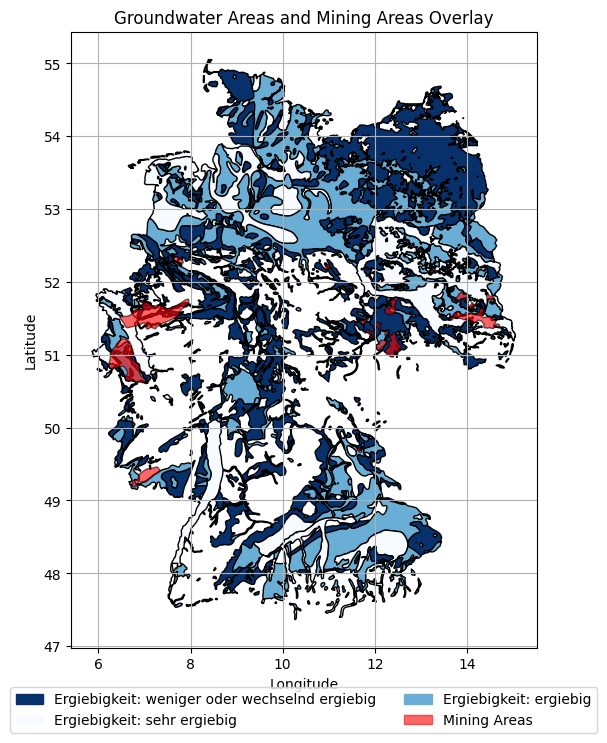

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))

# Plot groundwater areas with the color map
water_gdf.plot(ax=ax, column='erg_id', cmap='Blues',  edgecolor="black", legend=False)

# Overlay mining areas
mining_gdf.plot(ax=ax, color="red", alpha=0.6, edgecolor="black", label="Mining Areas")

plt.title("Groundwater Areas and Mining Areas Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Manually create patches for the groundwater categories using the same colormap
unique_categories = water_gdf['erg_id'].unique()
cmap = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=water_gdf['erg_id'].min(), vmax=water_gdf['erg_id'].max())

# Create legend patches with correct color mappings for 'ergiebigke'
# make dict erg_id and ergiebigke labels
unique_ids = water_gdf[['erg_id', 'ergiebigke']].drop_duplicates()
label_dict = dict(zip(unique_ids['erg_id'], unique_ids['ergiebigke']))
legend_patches = [mpatches.Patch(color=cmap(norm(value)), label=f"Ergiebigkeit: {label_dict[value]}") for value in unique_categories]

# Manually create a patch for mining areas
mining_patch = mpatches.Patch(color="red", alpha=0.6, label="Mining Areas")
legend_patches.append(mining_patch)



# Place the legend at the bottom center
plt.legend(handles=legend_patches, loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(True)
plt.show()




### ​Choropleth map for rock types

In [58]:
geo_gdf = gdfs['gwerg_gestein_v1_poly']
# remove missing rocktype (gestein) information
geo_gdf = geo_gdf.dropna() 

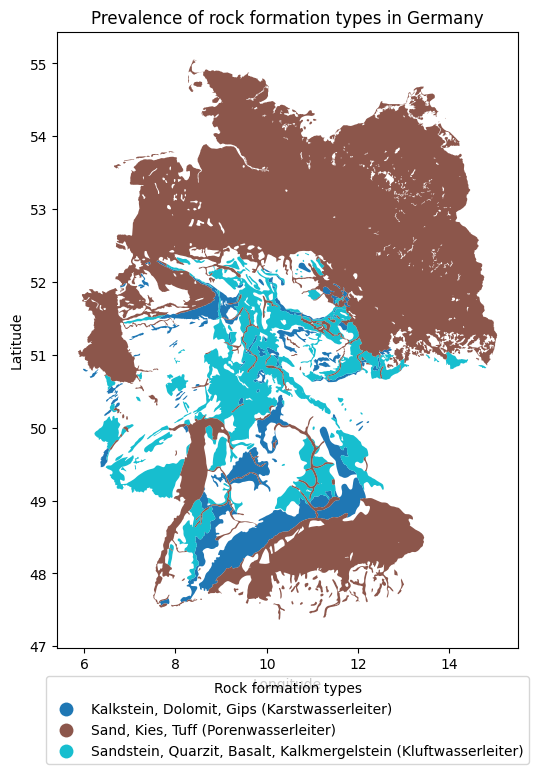

In [130]:
fig, ax = plt.subplots(figsize=(10, 8))

geo_gdf.plot(ax = ax,
             column = 'gestein', 
             legend=True, 
             legend_kwds={"loc": "lower center", 
                          "bbox_to_anchor": (0.5, -0.2), 
                          "title": "Rock formation types", 
                          
                          }
                          )
plt.title("Prevalence of rock formation types in Germany")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()